# Analysis of Google Trends data wrt U.S. 2016 presidential elections


In [238]:
import csv, os
import pandas as pd
import numpy as np
from numpy import *
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

In [239]:
DATA_DIR = 'data/'
BRBD = "interest_by_region_by_day/"

Let's first verify we are able to pull some data from Google Trends API

In [242]:
kw_list = ["Trump", "Clinton"]
timeframe = '2016-11-07 2016-11-07'
pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='US', gprop='')
temp_df = pytrends.interest_by_region(resolution='REGION')
temp_df.head()

,Trump,Clinton
geoName,,
Alabama,61,39
Alaska,64,36
Arizona,61,39
Arkansas,59,41
California,64,36


Looks ok. A few notes:
- Trends data is sampled so results for the same query vary slightly from day to day.
- Keywords are somewhat broadly matching. For example, keyword "Trump" will include any search query which has word "Trump" in it, such as "Donald J. Trump", but queries such as "Trumpett" will not match.
- Results are normalized so that each row sums up to 100. We can think of the 'Trump' column to be representing the **proportional search interest for Trump over Clinton.** For example, a value of 61 means that 61% of search queries (out of all Trump and Clinton related queries) were related to Trump (on a particular day in a particular state). **Can we use this search interest data to predict voter behavior?**

### Let's get Trends data for 100 days leading up to the election, per day, per state

In [139]:
# Google Trends request: 
from datetime import timedelta, date
end_date = date(2016, 11, 7)
day_count = 100
dres = {}
for single_date in (end_date - timedelta(n) for n in range(day_count)):
    date_str = str(single_date)
    timeframe = date_str + " " + date_str
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='US', gprop='')
    dres[date_str] = pytrends.interest_by_region(resolution='REGION')
assert len(dres) == day_count, "Expected 100 days' worth of data, but only got " + str(len(day_count))

In [140]:
# Save dataframes to files
for date in dres:
    df = dres[date]
    df.to_csv(DATA_DIR + BRBD + date + '.csv')

In [232]:
# Load dataframes from files
import os
dres = {}
directory = os.fsencode(DATA_DIR + BRBD)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    date_str = filename.split(".")[0]
    if filename.endswith(".csv"):
        filepath = DATA_DIR + BRBD + filename
        dres[date_str] = pd.read_csv(filepath)
        dres[date_str].set_index('geoName', inplace=True)

In [233]:
# Sanity check
print(end_date)
dres[str(end_date)].head()

2016-11-07


,Trump,Clinton
geoName,,
Alabama,61,39
Alaska,55,45
Arizona,64,36
Arkansas,57,43
California,65,35


Looks ok. Let's plot the data in order to understand it better.

In [280]:
# Create a series for each state, where index=dates, values=proportional searh interest for trump
dates = []
for date in sorted(dres):
    dates.append(date)

all_series = []
for state in dres[str(end_date)].index:
    series = pd.Series(index=dates)
    for date in sorted(dres):
        series.at[date] = dres[date].Trump.loc[state]
    all_series.append(series)

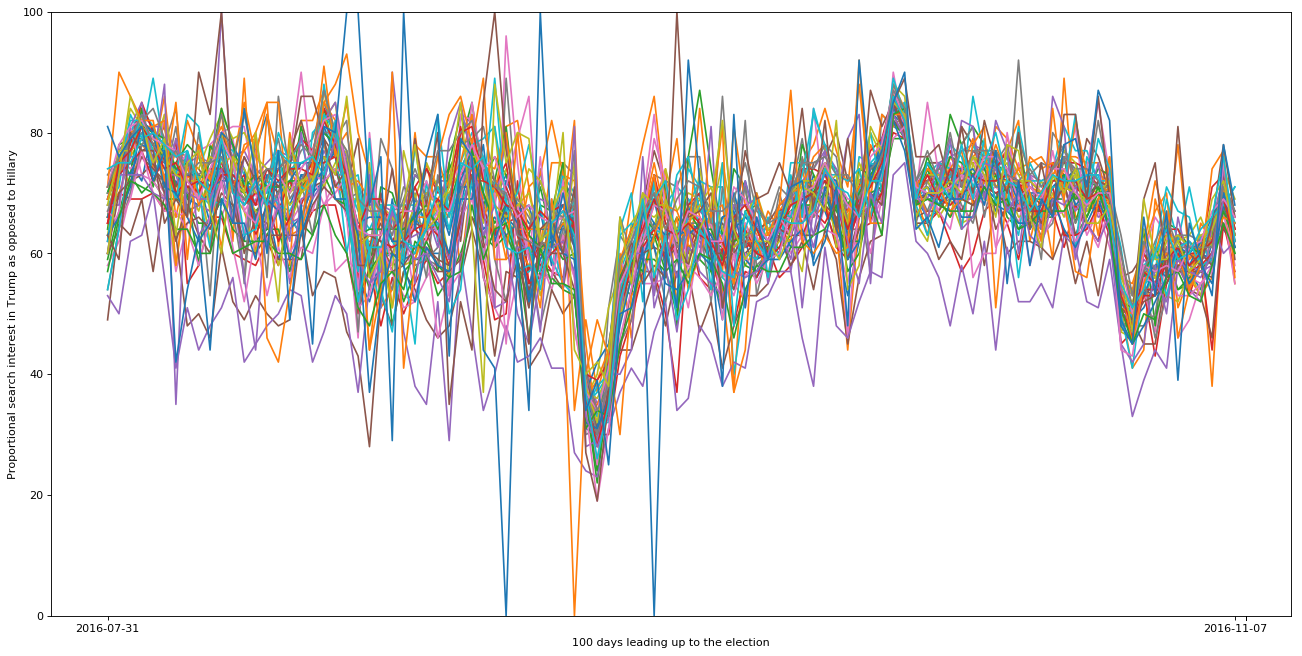

In [281]:
# Graph: Proportional interest in each state, per day
def plotStates():
    figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

    for series in all_series:
        plt.plot(series.index, series.values)

    # Clean up x values
    x_ticks = []
    last_index = len(dres) - 1
    for i,date in enumerate(sorted(dres)):
        if i in [0, last_index]:
            x_ticks.append(str(date))
        else:
            x_ticks.append('')
    plt.xticks(x_ticks)

    plt.xlabel("100 days leading up to the election")
    plt.ylabel("Proportional search interest in Trump as opposed to Hillary")
    plt.ylim(0, 100)
    plt.show()

plotStates()

Each plot in this figure represents a state. The x axis represents days leading up to the election, the y axis represents proportional search interest in favor of Trump, from 0 to 100%.

What we learn from this figure:
- Search interest across states is fairly correlated, as we might expect
- Some states are consistently more/less favorable to Trump compared to average, as we might expect
- Timeframe of 1 day might be too short for meaningful analysis, as the values vary wildly from day to day, presumably according to daily news flow
- There are some clearly erroneous outliers of 0 and 100

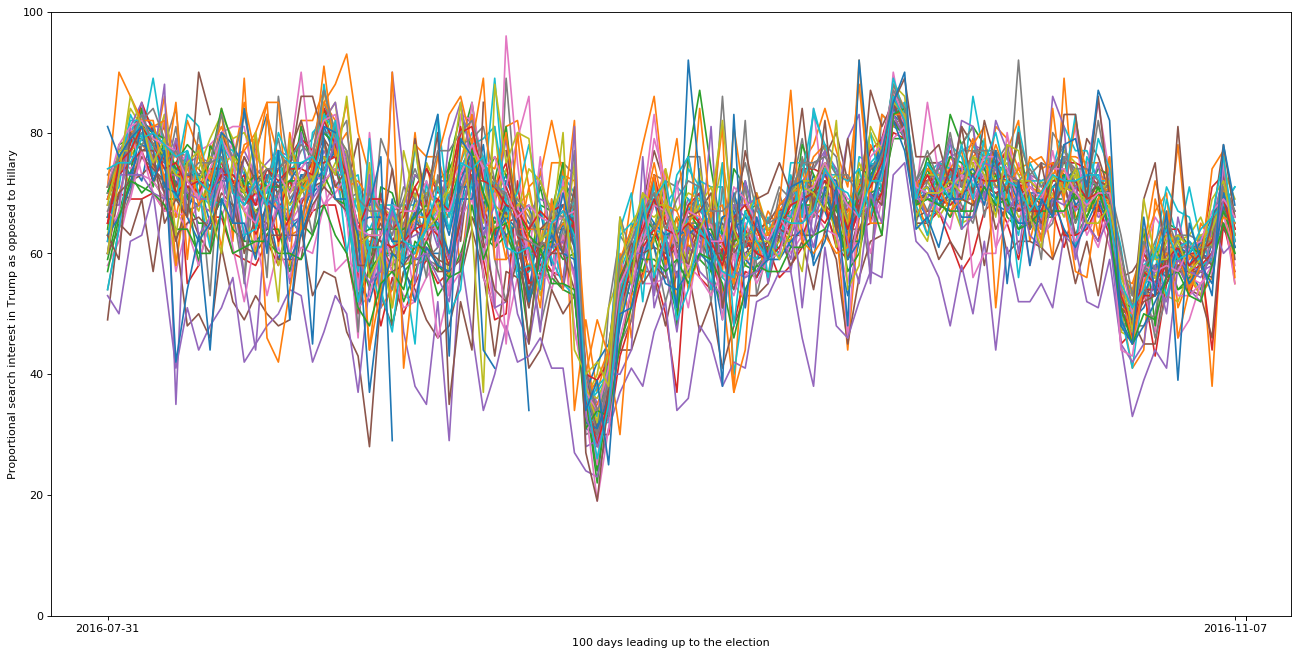

In [282]:
# Clean up clearly erroneous values (0, 100)
for series in all_series:
    for date in series.index:
        if series.at[date] in [0, 100]:
            series.at[date] = np.NaN
            
plotStates()

### RQ1: Does the search interest of a state on the day before election correlate with election results?
We don't expect many voters to change their vote during the night before election, so this 1 day lag between queries and voting should be acceptable. We would expect people to make more search queries related to their preferred candidate. Perhaps not in the absolute sense, but at least in the relative sense. For example, if Trump received higher than average search interest in Wyoming the day before election, we would expect him to receive higher than average share of votes in Wyoming.

To be clear, this RQ is more like a preliminary check "are these results predictive at all". Even if these results are _predictive_, they may not be _useful_ (in order for results to be useful, they would have to surpass comparable baseline predictors such as polling data, historical party affiliation of a state, or betting odds offered by gambling outlets).

In [274]:
# Load voting data from file
filepath = DATA_DIR + "votes.csv"
votes_df = pd.read_csv(filepath)
print(votes_df.size)

4830


In [275]:
# Verify we have the same states in both datasets
states1 = set()
for state in votes_df['state']:
    states1.add(state)
states2 = set()
for state in dres[str(end_date)].index:
    states2.add(state)
for state in states1:
    assert state in states2
for state in states2:
    assert state in states1

In [276]:
votes_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,2016,Alabama,AL,1,63,41,US President,"Trump, Donald J.",republican,False,1318255,2123372,20171015,NaN
1,2016,Alabama,AL,1,63,41,US President,"Clinton, Hillary",democrat,False,729547,2123372,20171015,NaN
2,2016,Alabama,AL,1,63,41,US President,"Johnson, Gary",libertarian,False,44467,2123372,20171015,NaN
3,2016,Alabama,AL,1,63,41,US President,NaN,NaN,True,21712,2123372,20171015,NaN
4,2016,Alabama,AL,1,63,41,US President,"Stein, Jill",green,False,9391,2123372,20171015,NaN


Looks ok. Let's focus on the main 2 candidates only.

In [278]:
# Create dict where key=state, value=Trump/(Trump+Clinton)
votes = {} 

def get_votes_of(candidate):
    return votes_df.loc[(votes_df['candidate'] == candidate) & (votes_df['state'] == state)]['candidatevotes'].values[0]

for state in sorted(states1):
    trump_votes = get_votes_of('Trump, Donald J.')
    clinton_votes = get_votes_of('Clinton, Hillary')
    votes[state] = trump_votes * 1.0 / (trump_votes + clinton_votes)

In [307]:
# Create df where index=states, column1=search_interest, column2=voter_share
rq1_df = pd.DataFrame(index=sorted(states1), columns=["search_interest", "voter_share"])
for state in sorted(states1):
    rq1_df.loc[state]['search_interest'] = dres[str(end_date)].Trump.loc[state]
    rq1_df.loc[state]['voter_share'] = round(100 * votes[state])

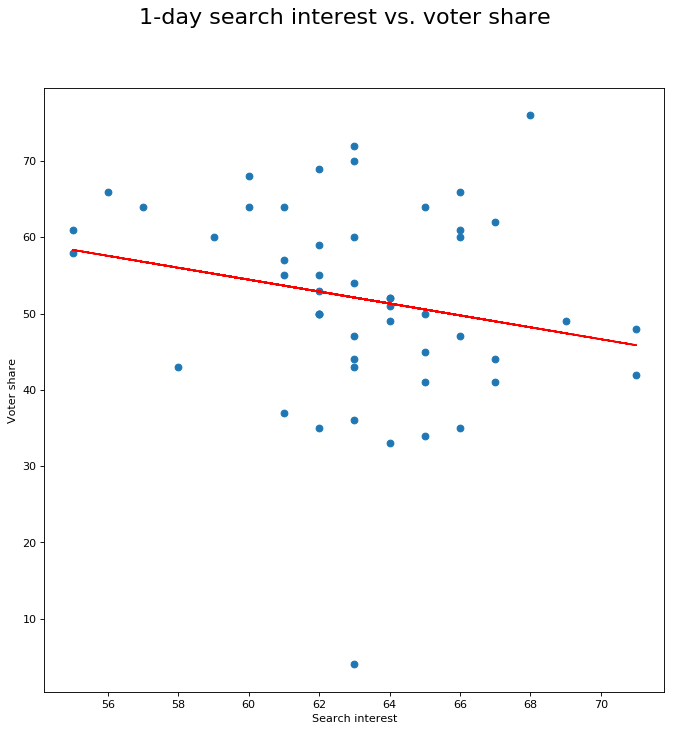

In [326]:
# Plot relationship between 1-day-search-interest and voting behavior
def plotRQ1(df, days):
    fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    x = df.search_interest
    y = df.voter_share
    plt.scatter(x,y)
    
    # Calc the trendline (https://stackoverflow.com/a/26447505/4490400)
    z = np.polyfit(x.astype(float), y.astype(float), 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    
    fig.suptitle(str(days) + "-day search interest vs. voter share", fontsize=20)
    plt.xlabel("Search interest")
    plt.ylabel("Voter share")
    plt.show()

plotRQ1(rq1_df, 1)

There doesn't seem to be a clear correlation, and if there is, it's surprisingly negative (meaning, people would search more for the opposing candidate rather than their preferred candidate). The outlier is DC:

In [299]:
rq1_df.loc['District of Columbia']

search_interest    63
voter_share         4
Name: District of Columbia, dtype: object

I verified that it really is the actual election result from DC, not an error in data.

Maybe there is too much noise in 1-day search interest data. Let's try average of X days before election.

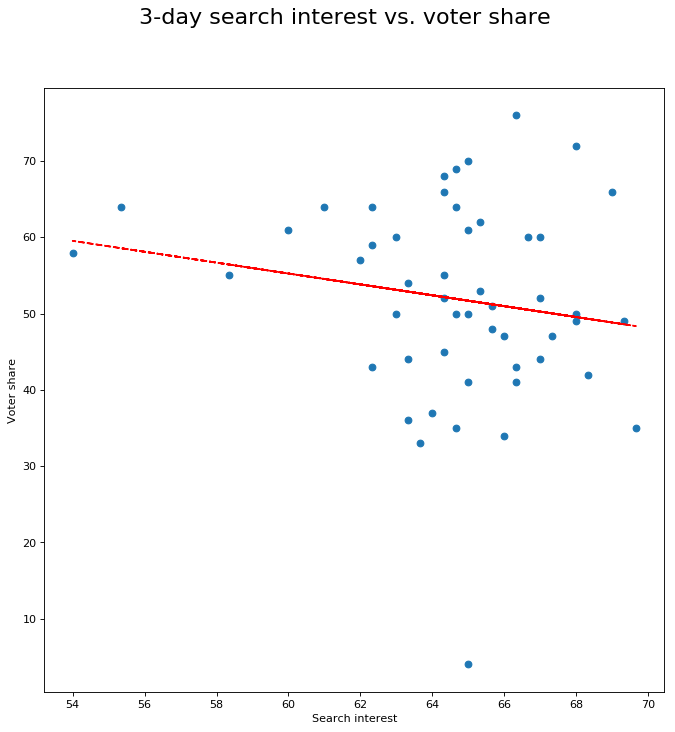

In [337]:
def get_search_average(state, count_days):
    sum_values = 0
    for date in (end_date - timedelta(n) for n in range(count_days)):
        sum_values += dres[str(date)].Trump.loc[state]
    return sum_values * 1.0 / count_days

def create_df_rq(count_days):
    df = pd.DataFrame(index=sorted(states1), columns=["search_interest", "voter_share"])
    for state in sorted(states1):
        df.loc[state]['search_interest'] = get_search_average(state, count_days)
        df.loc[state]['voter_share'] = round(100 * votes[state])
    return df
    
plotRQ1(create_df_rq(3), 3)

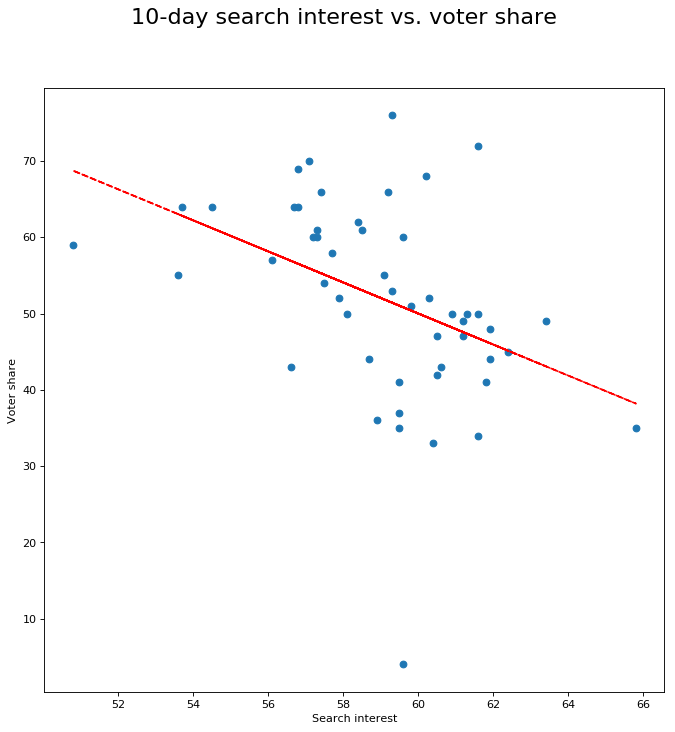

In [338]:
plotRQ1(create_df_rq(10), 10)

Not sure what to make of this really.

In [57]:
# TODO: RQ2: Let's look at the timeframe between last public polls and election day.
# Does the *change* in interest during this timeframe predict the change between
# polling results and voting results?

In [59]:
# Graph: Proportional interest in U.S. over time compared to poll results over time
# + calculate correlation